# Prediction of Staining
This notebook can be used to predict images with existing models and plot the output, compare it to the target images, plot histograms etc.

In [1]:
import os
import os.path
import numpy as np
import glob
import matplotlib.pyplot as plt
import preprocessing_functions as pre
import training_functions as training
import skimage.io
import prediction as pred
import keras

Load d0-images you want to convert and the d1 and d2 images for comaprison.

In [3]:
# define directories
wrk_dir = r"C:\Users\tsche\Desktop\Master\2. Semester\Project Staining"
image_folder = 'Val_Images'
im_dir = os.path.join(wrk_dir, image_folder, '*.png')
imd0_dir = os.path.join(wrk_dir, image_folder, '*d0.png')

In [4]:
#load images
d0_images = glob.glob(imd0_dir)
d0_stack = pre.stack_images(d0_images, num_channels = 1)
images = glob.glob(im_dir)
d12_images =  [x for x in images if x not in d0_images]
d12_stack= pre.stack_images(d12_images, num_channels = 2)

In [5]:
# normalize images
(d0_norm, mean, std) = pre.norm_batch(d0_stack)
d12_norm = pre.norm(d12_stack, mean, std)

Plot images and histograms if intrested.

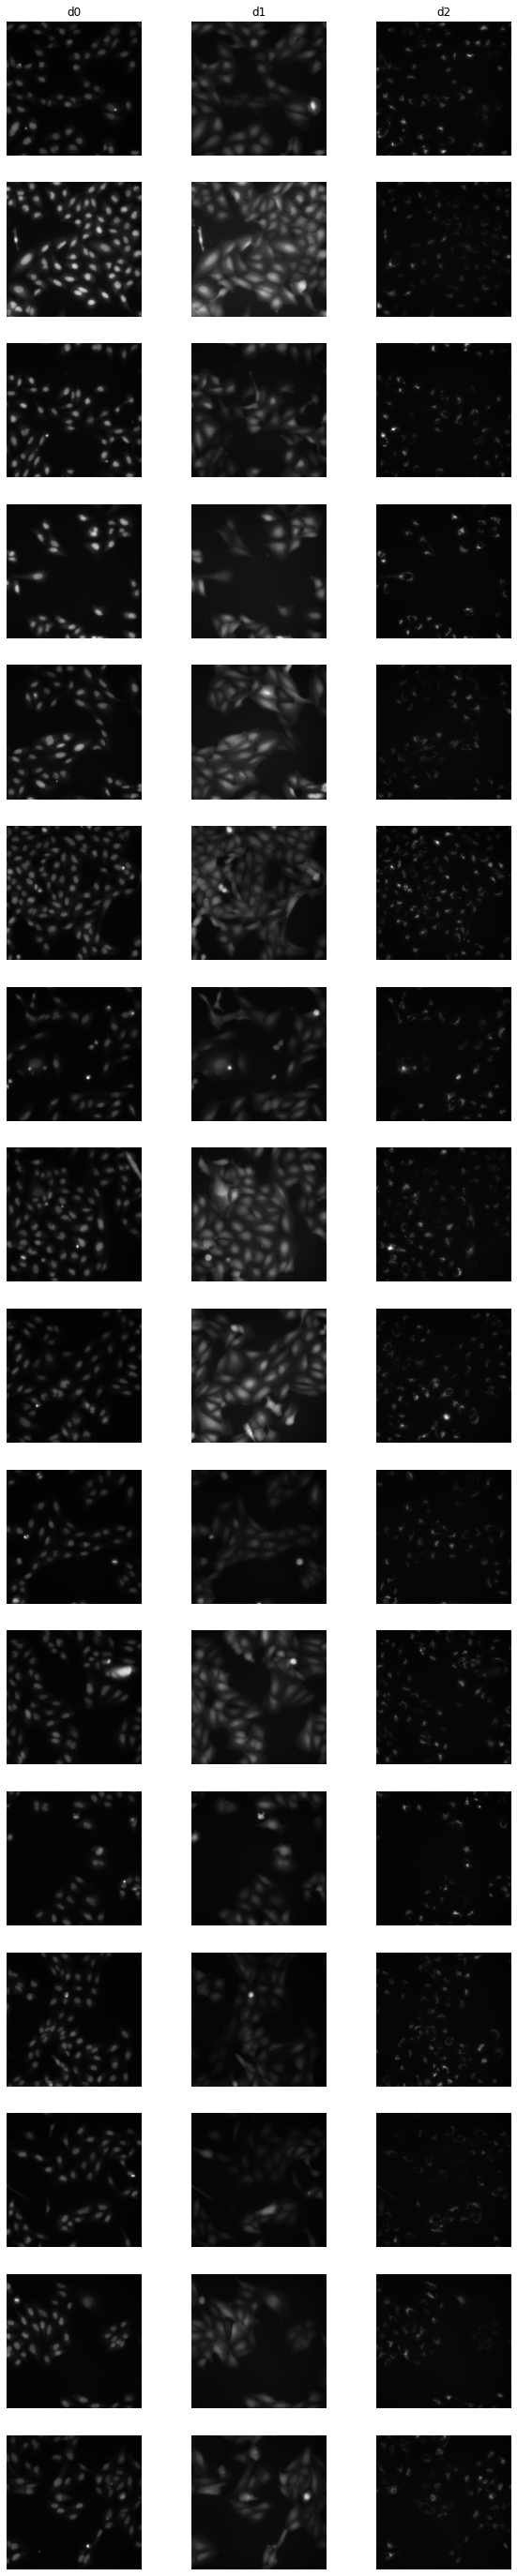

In [19]:
# plot images
plt.figure(figsize=(10,50)) 
n = d0_stack.shape[0]
for p in range(n):
    plt.subplot(n,3,1+3*p)    
    plt.imshow(d0_stack[p], cmap='gray')
    plt.axis('off')
    if p == 0:
        plt.title('d0')

    plt.subplot(n,3,2+3*p)    
    plt.imshow(d12_stack[p,:,:,0], cmap='gray')
    plt.axis('off')
    if p == 0:
        plt.title('d1')
    
    plt.subplot(n,3,3+3*p)    
    plt.imshow(d12_stack[p,:,:,1], cmap='gray')
    plt.axis('off')
    if p == 0:
        plt.title('d2')

In [1]:
# plot histograms
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
histogram, bin_edges = np.histogram(d0_stack[0], bins=65535, range=(0,65535))
plt.plot(bin_edges[0:-1], histogram)  
plt.title("input")

plt.subplot(2,3,2)
histogram, bin_edges = np.histogram(d12_stack[0,:,:,0], bins=65535, range=(0,65535))
plt.plot(bin_edges[0:-1], histogram)  
plt.title("d1 output")

plt.subplot(2,3,3)
histogram, bin_edges = np.histogram(d12_stack[0,:,:,1], bins=65535, range=(0,65535))
plt.plot(bin_edges[0:-1], histogram)  
plt.title("d2 output")

plt.subplot(2,3,4)
histogram, bin_edges = np.histogram(d0_norm[0], bins=65535, range=(-1,10))
plt.plot(bin_edges[0:-1], histogram)  
plt.title("Normalized input")

plt.subplot(2,3,5)
histogram, bin_edges = np.histogram(d12_norm[0,:,:,0], bins=65535, range=(-1,10))
plt.plot(bin_edges[0:-1], histogram)  
plt.title("Normalized  d1 output")

plt.subplot(2,3,6)
histogram, bin_edges = np.histogram(d12_norm[0,:,:,1], bins=65535, range=(-1,10))
plt.plot(bin_edges[0:-1], histogram)  
plt.title("Normalized  d2 output")

plt.show()

NameError: name 'plt' is not defined

Load desired model and convert images

In [6]:
import loss_functions as lf
model_name = 'd1d2_32im_ssim2'
mdl_dir = r'..\models'
model = keras.models.load_model(os.path.join(mdl_dir,model_name), custom_objects={ 'SSIMLoss': lf.SSIMLoss(d12_norm[0], d12_norm[0]) })

In [5]:
model_name = 'd1d2_32im'
mdl_dir = r'..\models'
model = keras.models.load_model(os.path.join(mdl_dir,model_name))

In [17]:
# change input layer of model 
new_model = training.get_model(1104,1104)
new_model.set_weights(model.get_weights())

Input (None, 1104, 1104, 1)
1. Conv (None, 552, 552, 64)
2. conv (None, 552, 552, 128)
3. conv (None, 276, 276, 256)
4. conv (None, 138, 138, 512)
1. UpConv (None, 276, 276, 768)
2. UpConv (None, 552, 552, 384)
3. UpConv (None, 1104, 1104, 192)


In [18]:
num_im = d0_norm.shape[0]
out =[]
for n in range(1):
    image = d0_norm[n]
    output = pred.predict(new_model, image, 1104, 1104, num_outputs=2)
    output_norm = pre.unnormalize(output, mean, std)
    out.append(output)
out = np.stack(out, axis = 0)

(4, 1104, 1104, 2)


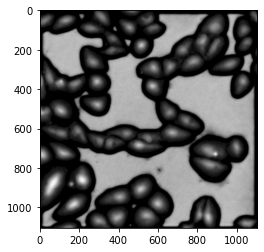

In [20]:
plt.imshow(out[0,:,:,0], cmap='gray')

Lossy conversion from float64 to uint8. Range [0.0, 7.804375171661377]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 6.371232986450195]. Convert image to uint8 prior to saving to suppress this warning.


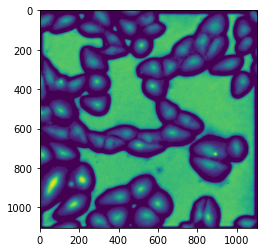

In [21]:
name = 'ssim_changedInput'
plt.imshow(out[0,:,:,0])
im = out[0,:,:,0]
dir_d1 = os.path.join(r'C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\gitrepo\TeresaScheidt\training_results', name + '_d1.png')
dir_d2 = os.path.join(r'C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\gitrepo\TeresaScheidt\training_results', name +'_d2.png')
skimage.io.imsave(dir_d1, im)
im = out[0,:,:,1]
skimage.io.imsave(dir_d2, im)

Plot predicted images and histograms of output.

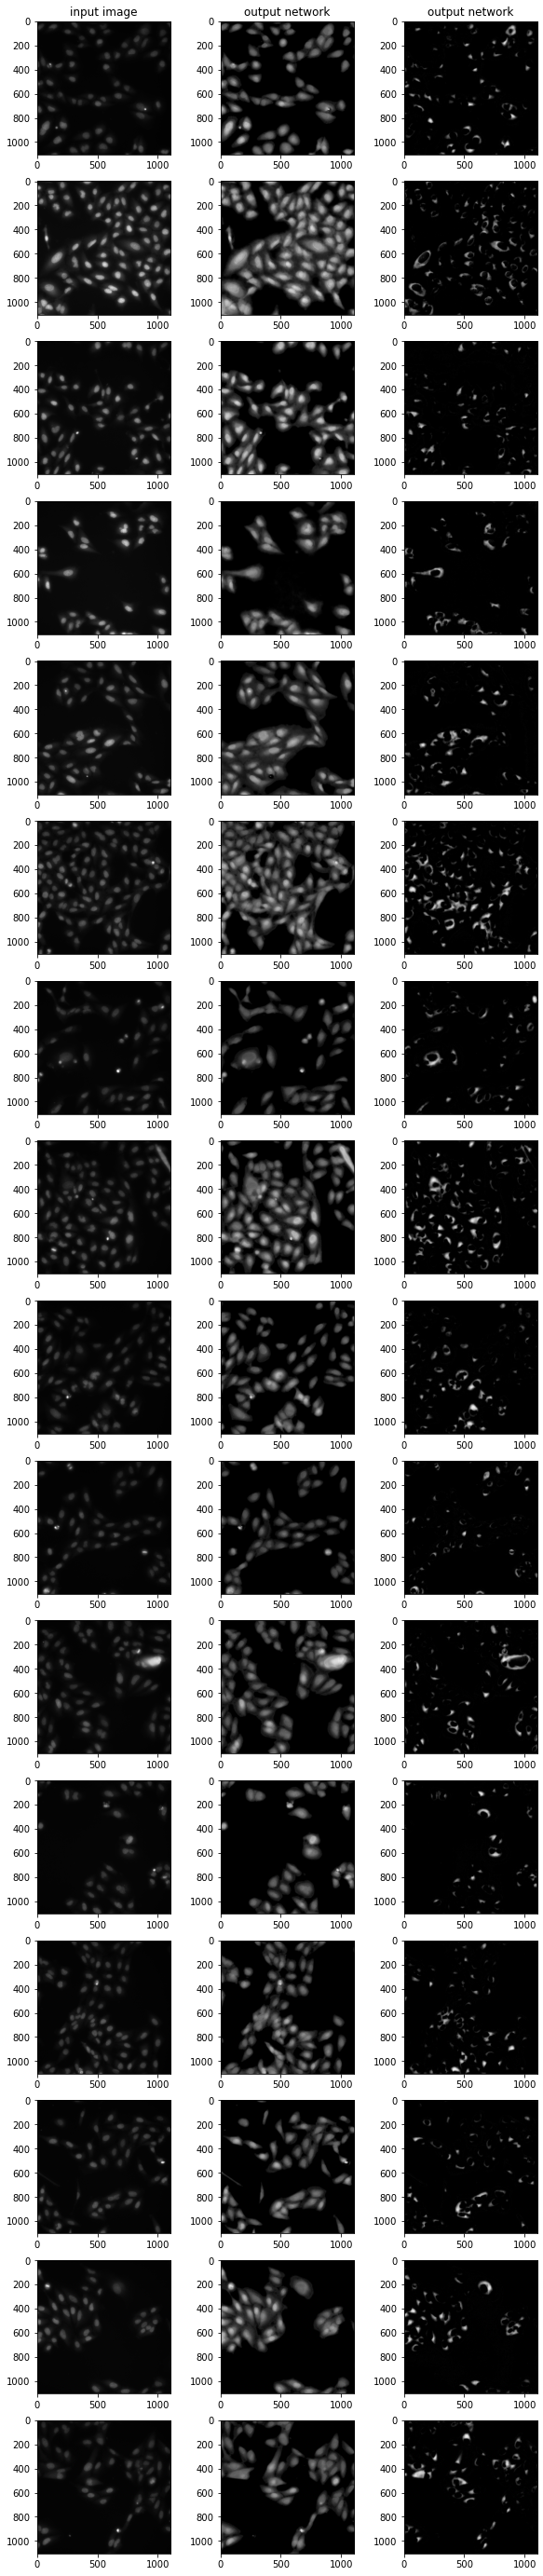

In [73]:
# plot predicted images
plt.figure(figsize=(10,50)) 
n = out.shape[0]
for p in range(n):
    plt.subplot(n,3,1+3*p)    
    plt.imshow(d0_stack[p], cmap='gray')
    if p == 0:
        plt.title('input image')

    plt.subplot(n,3,2+3*p)    
    plt.imshow(out[p,:,:,0], cmap='gray')
    if p == 0:
        plt.title('output network')
    
    plt.subplot(n,3,3+3*p)    
    plt.imshow(out[p,:,:,1], cmap='gray')
    if p == 0:
        plt.title('output network')

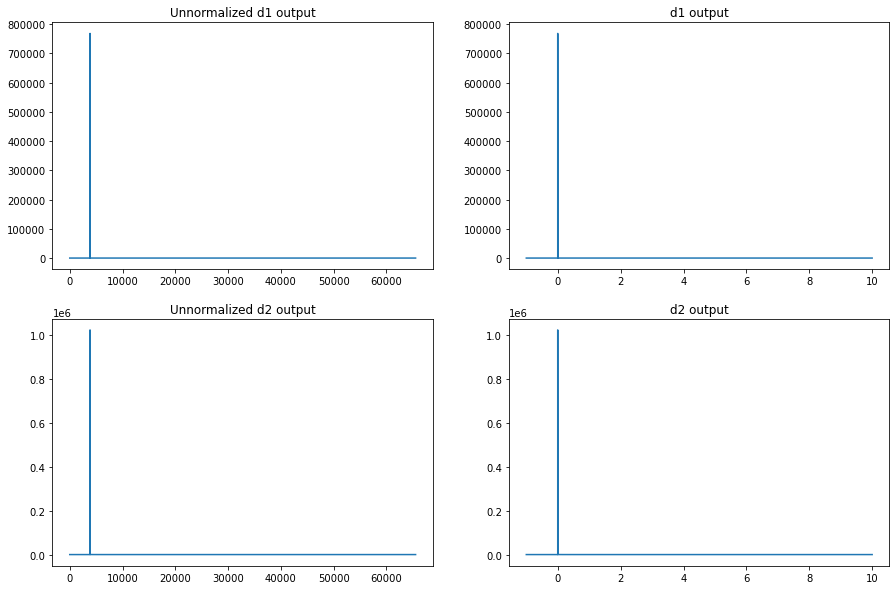

In [67]:
# plot histogram of converted image
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
histogram, bin_edges = np.histogram(output_norm[:,:,0], bins=65535, range=(0,65535))
plt.plot(bin_edges[0:-1], histogram)  
plt.title("Unnormalized d1 output")

plt.subplot(2,2,2)
histogram, bin_edges = np.histogram(output[:,:,0], bins=65535, range=(-1,10))
plt.plot(bin_edges[0:-1], histogram)  
plt.title("d1 output")

plt.subplot(2,2,3)
histogram, bin_edges = np.histogram(output_norm[:,:,1], bins=65535, range=(0,65535))
plt.plot(bin_edges[0:-1], histogram)  
plt.title("Unnormalized d2 output")

plt.subplot(2,2,4)
histogram, bin_edges = np.histogram(output[:,:,1], bins=65535, range=(-1,10))
plt.plot(bin_edges[0:-1], histogram)  
plt.title("d2 output")

plt.savefig()
plt.show()